In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
currentDirectory = os.getcwd()
os.chdir(os.path.dirname(currentDirectory))
from TDOA_estimation import EllipticFilter, GCC_PHAT, CrossCorr
import time
from scipy.signal import filtfilt, ellip, freqz, lfilter
import matplotlib.pyplot as plt

from unit_test_utils import GenerateSinPulses

## Generate and visualize test signals

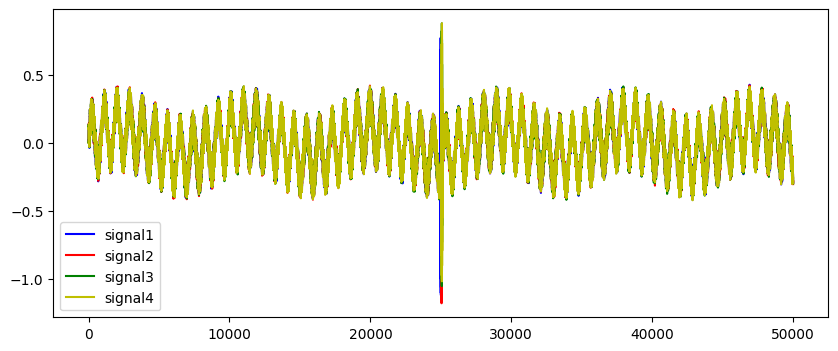

In [90]:
sampleRate = 100000
duration = 0.5
offsets = [54,70,76]
pulseFrequency = 20000
numPulseCycles = 4
otherFreqs = [70,700,8000]
otherAmps = [.1,0.2,.1]
noiseScale = .01

signal1, signal2, signal3, signal4, trueTDOAs = GenerateSinPulses(sampleRate, duration, offsets, 
                                                                   pulseFrequency, numPulseCycles, 
                                                                   otherFreqs, otherAmps, noiseScale)


zoom = False # Set this value to true to zoom in on the pulses
plt.figure(figsize=(10,4))

startPoint = 0
endPoint = len(signal1)
if zoom:
    startPoint = 24500
    endPoint = 25500
    
plt.plot(signal1[startPoint:endPoint],c= 'b', label = "signal1")
plt.plot(signal2[startPoint:endPoint], c= 'r', label = "signal2")
plt.plot(signal3[startPoint:endPoint],c= 'g', label = "signal3")
plt.plot(signal4[startPoint:endPoint], c= 'y', label = "signal4")
plt.legend()
plt.show()

## Produce and Visualize Elliptic filter

b coefficients: [ 0.49580191 -1.9260157   2.8613285  -1.9260157   0.49580191]
a coefficients: [ 1.         -2.53934052  2.67821627 -1.31270499  0.26392123]


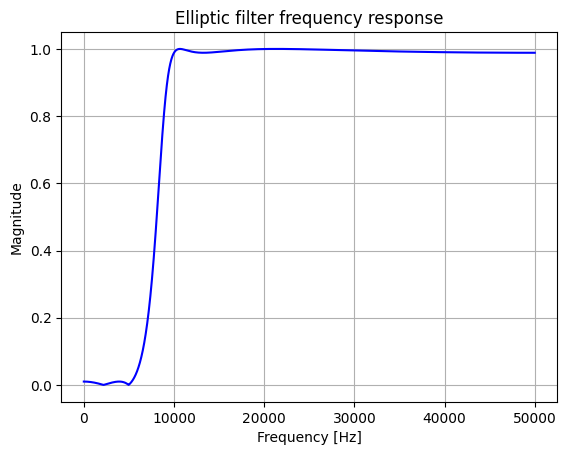

In [91]:
order = 4
ripple_dB = 0.1
cutoffFrequency = 10000

b, a = EllipticFilter(order, ripple_dB, cutoffFrequency, sampleRate)
print("b coefficients:", b)
print("a coefficients:", a)

# Frequency response
w, h = freqz(b, a, worN=8000)
plt.figure()
plt.plot(0.5*sampleRate*w/np.pi, np.abs(h), 'b')
plt.title("Elliptic filter frequency response")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

## Estimate TDOAs using non-filtered and filtered signals 

 ------ TDOA using cross-correlation with non-filtered signals: 
Runtime:  6.46885085105896
TDOA predictions: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
TDOA Error: 
1.198666e-03
 ------ TDOA using GCC_PHAT with non-filtered signals: 
[[ 0.       0.       0.       0.     ]
 [-0.0006   0.       0.       0.     ]
 [-0.0007   0.       0.       0.     ]
 [-0.00075  0.       0.       0.     ]]
Runtime:  0.10179615020751953
TDOA predictions: 
[[ 0.       0.       0.       0.     ]
 [-0.0006   0.       0.       0.     ]
 [-0.0007   0.       0.       0.     ]
 [-0.00075  0.       0.       0.     ]]
TDOA Error: 
2.851315e-04


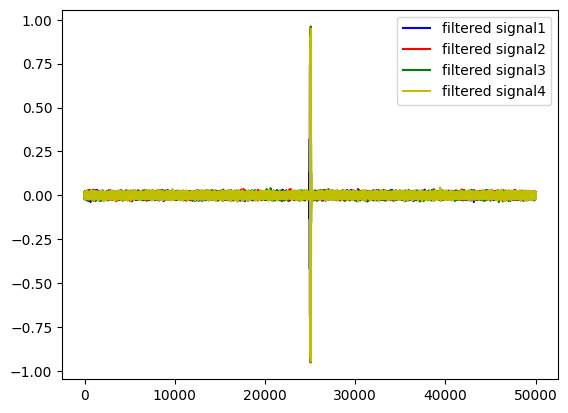

 ------ TDOA using cross-correlation with non-filtered signals: 
Runtime:  6.467001914978027
TDOA predictions: 
[[ 0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [-5.5e-04  0.0e+00  0.0e+00  0.0e+00]
 [-7.0e-04 -1.5e-04  0.0e+00  0.0e+00]
 [-7.5e-04 -2.0e-04 -5.0e-05  0.0e+00]]
TDOA Error: 
2.828427e-05
 ------ TDOA using GCC_PHAT with non-filtered signals: 
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-5.50625e-04  0.00000e+00  0.00000e+00  0.00000e+00]
 [-7.00000e-04 -2.00000e-04  0.00000e+00  0.00000e+00]
 [-7.00625e-04 -2.50000e-04 -5.00000e-05  0.00000e+00]]
Runtime:  0.09833288192749023
TDOA predictions: 
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-5.50625e-04  0.00000e+00  0.00000e+00  0.00000e+00]
 [-7.00000e-04 -2.00000e-04  0.00000e+00  0.00000e+00]
 [-7.00625e-04 -2.50000e-04 -5.00000e-05  0.00000e+00]]
TDOA Error: 
7.898279e-05


In [92]:

#######################
## non-filtered signals
#######################

dataMatrix = np.vstack(np.array([signal1, signal2, 
                                 signal3, signal4]))

print(" ------ TDOA using cross-correlation with non-filtered signals: ")
startTime = time.time()
tdoaEstimates = CrossCorr(dataMatrix, sampleRate)
print("Runtime: ", time.time() - startTime)
print("TDOA predictions: ")
print(tdoaEstimates)
print("TDOA Error: ")
error = np.sqrt(np.sum((tdoaEstimates - trueTDOAs)**2))
print("{:e}".format(error))

print(" ------ TDOA using GCC_PHAT with non-filtered signals: ")
startTime = time.time()
tdoaEstimates = GCC_PHAT(dataMatrix, sampleRate, max_tau=None, interp=16)
print(tdoaEstimates)
print("Runtime: ", time.time() - startTime)
print("TDOA predictions: ")
print(tdoaEstimates)
print("TDOA Error: ")
error = np.sqrt(np.sum((tdoaEstimates - trueTDOAs)**2))
print("{:e}".format(error))
dataMatrix = 0 # clear memory

#######################
## filtered signals
#######################

signal1_filtered = filtfilt(b, a, signal1)
signal2_filtered = filtfilt(b, a, signal2)
signal3_filtered = filtfilt(b, a, signal3)
signal4_filtered = filtfilt(b, a, signal4)


plt.plot(signal1_filtered, c= 'b', label = "filtered signal1")
plt.plot(signal2_filtered, c= 'r', label = "filtered signal2")
plt.plot(signal3_filtered, c= 'g', label = "filtered signal3")
plt.plot(signal4_filtered, c= 'y', label = "filtered signal4")
plt.legend()
plt.show()

dataMatrixFiltered = np.vstack(np.array([signal1_filtered, signal2_filtered, 
                                 signal3_filtered, signal4_filtered]))

print(" ------ TDOA using cross-correlation with non-filtered signals: ")
startTime = time.time()
tdoaEstimates = CrossCorr(dataMatrixFiltered, sampleRate)
print("Runtime: ", time.time() - startTime)
print("TDOA predictions: ")
print(tdoaEstimates)
print("TDOA Error: ")
error = np.sqrt(np.sum((tdoaEstimates - trueTDOAs)**2))
print("{:e}".format(error))


print(" ------ TDOA using GCC_PHAT with non-filtered signals: ")
startTime = time.time()
tdoaEstimates = GCC_PHAT(dataMatrixFiltered, sampleRate, max_tau=None, interp=16)
print(tdoaEstimates)
print("Runtime: ", time.time() - startTime)
print("TDOA predictions: ")
print(tdoaEstimates)
print("TDOA Error: ")
error = np.sqrt(np.sum((tdoaEstimates - trueTDOAs)**2))
print("{:e}".format(error))
dataMatrixFiltered = 0 # clear memory

## Calculate average runtime of applying Elliptical filter in the forward and backward directions

In [93]:
print("Run time test: ")
filterStartTime = time.time()
N = 10000
print(len(signal1))
for i in range(N):
    _ = filtfilt(b, a, signal1)

runTime = time.time() - filterStartTime
print("{:e}".format(runTime / N))

Run time test: 
50000
8.240323e-04


In [52]:
N = 5000
filterStartTime = time.time()


dataMatrixFiltered = np.vstack(np.array([signal1_filtered, signal2_filtered, 
                                 signal3_filtered, signal4_filtered]))
for i in range(N):
    signal1_filtered = filtfilt(b, a, signal1)
    signal2_filtered = filtfilt(b, a, signal2)
    signal3_filtered = filtfilt(b, a, signal3)
    signal4_filtered = filtfilt(b, a, signal4)
    
    #tdoaEstimates = CrossCorr(dataMatrixFiltered, sampleRate)
    tdoaEstimates = GCC_PHAT(dataMatrixFiltered, sampleRate, max_tau=None, interp=16)
runTime = time.time() - filterStartTime
print("{:e}".format(runTime / N))


KeyboardInterrupt



In [95]:
N = 500000
filterStartTime = time.time()



for i in range(N):
    dataMatrixFiltered = np.vstack(np.array([signal1_filtered, signal2_filtered, 
                                 signal3_filtered, signal4_filtered]))
    dataMatrixFiltered = 0
    
runTime = time.time() - filterStartTime
print("{:e}".format(runTime / N))

1.350877e-04


In [89]:
3.16
1.66
2.16

2.16